In [1]:
from __future__ import division, print_function, unicode_literals

import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
from tada import wires_functions
from tada import capsule_functions
import tensorflow as tf
import numpy as np
import imageio as io

#checkpoint_path="./1804192_2D_simple_cable"
tf.reset_default_graph()


# I rebuild the exact same graph used for training below

In [2]:
epsilon = 1e-5
batch_size = 4
imsize = 32

x = tf.placeholder(shape=[None, imsize, imsize, 1], dtype=tf.float32, name="X")

# ------- ReLU layer -------- #
# kernel size = [5, 5]
# out_channels = 16
# stride = 1 with padding ('same')
ReLU_conv1 = capsule_functions.conv2d(x, 5, 16, 1, 'SAME', 'ReLU_conv1', True, tf.nn.relu)

# ------- PrimaryCaps layer -------- #
# kernel size = [5, 5]
# out_capsules = 16
# stride = 1 with padding ('same')
# pose shape = [4, 4]
PrimaryCaps = capsule_functions.primary_caps(ReLU_conv1, 5, 16, 1, 'SAME', (4, 4), "PrimaryCaps")

# spatial dimension = image dimension
# ------- ConvCaps layer -------- #
# i = number of input capsules
# o = number of output capsules
# convolution operation kernel, [kh, kw, i, o] = (3, 3, 16, 2)
# stride = 1 (1,1,1,1) with padding ('same')
# iteration (EM routing) = 3
ConvCaps0, a, b = capsule_functions.conv_capsule(PrimaryCaps, (3, 3, 16, 2), (1, 1, 1, 1), 3, batch_size, "ConvCaps0", 'SAME')
#ConvCaps1 = capsule_functions.class_capsules(ConvCaps0, 1, iterations=3, batch_size=batch_size, name='class_capsules')

# ConvCaps0[0]: [4, 32, 32, 2, 4, 4]

# Select one output capsule
ConvCaps01 = ConvCaps0[0][:,:,:,0,:,:],ConvCaps0[1][:,:,:,0]
ConvCaps1 = ConvCaps01[0][:,:,:,tf.newaxis,:,:],ConvCaps01[1][:,:,:,tf.newaxis]

y = tf.placeholder(shape=[batch_size, imsize, imsize, 17], dtype=tf.float32, name="y")

# ConvCaps1[0]: [4, 32, 32, 1, 4, 4]
# y_final_0: [4, 32, 32, 1, 16] # pose label
y_final_0 = tf.reshape(ConvCaps1[0], [batch_size, imsize, imsize, -1, 16], name="y_final_0")

# ConvCapse1[1]: [4, 32, 32, 1]
# y_final_1: [4, 32, 32, 1, 1] # activation label
y_final_1 = tf.expand_dims(ConvCaps1[1], -1, name="y_final_1")

# Merge pose and activation labels
# y_pred_f: [4, 32, 32, 1, 17]
# y_pred: [4, 32, 32, 17]
y_pred_f = tf.concat([y_final_0, y_final_1], axis=4, name="y_pred_f")
y_pred = tf.squeeze(y_pred_f, axis=3, name="y_pred")

gstep = tf.placeholder(shape=(), dtype=tf.float32, name="gstep")

diff_y = tf.subtract(y, y_pred, name="diff_y")
squa_y = tf.square(diff_y, name="squa_y") 

loss = tf.reduce_mean(squa_y, name="loss")

y_group = tf.squeeze(ConvCaps1[1] > 0.5, 3, name="y_group")
y_real = y[:, :, :, 16] > 0.5

correct = tf.equal(y_real, y_group, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters

print(total_parameters)

tf.trainable_variables()

# Tried option: learning_rate = 0.001 / 0.0001
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")
#global_step = tf.train.get_or_create_global_step()
#training_op = slim.learning.create_train_op(tf.clip_by_value(loss, 1e-5, 1.0), optimizer, global_step=global_step, clip_gradient_norm=4.0)

saver = tf.train.Saver()
var_init = tf.global_variables_initializer()

#checkpoint_path = "./1804192_2D_simple_cable"


init = tf.constant_initializer(0.0)


114100


# I reload all the trained layers. The "session" contains all executable layers

In [3]:
checkpoint_path = "./180424_test"
sess=tf.Session()
saver.restore(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./180424_test


In [4]:
#What am I interested in ? For the network to run an input file, and produce a prediction
#What do I give ? a batch of images to run. It can only run now a batch of 4x32x32 images.
#It cannot run 1x32x32 or anything else than 4x32x32

x_test, y_test = wires_functions.gen_wires(n_data=50, length=20, n_wires=2, imsize=32)



input_images=x_test[:4,:,:,:] #the first 4.

In [ ]:
predictions=sess.run([y_pred], feed_dict={x:input_images})
#you only want to evaluate the y_pred tensor of the model
#this tensor only needs the input images, no other parameters, so the feed_dict consists only of the images. 
#the input variable in the model is the placeholder called x, so in the feed_dict it's referred to as x.
print (np.shape(predictions),'output of model')
predictions=np.asarray(predictions).reshape(batch_size,imsize,imsize,17)
print (np.shape(predictions), 'reshaped')

In [1]:
f,a=plt.subplots(3,2,figsize=(8,12))
batch_index=1
titles=['x proj','y proj', 'intensity']

for idx,i in enumerate([0,1,-1]):
    im1=a[idx,0].imshow(predictions[batch_index,:,:,i])#,vmin=0,vmax=1)
    im2=a[idx,1].imshow(y_test[batch_index,:,:,i])#,vmin=0,vmax=1)
    f.colorbar(im1, ax=a[idx,0])
    f.colorbar(im2, ax=a[idx,1])
    a[idx,0].set_title(titles[idx]+' pred')
    a[idx,1].set_title(titles[idx]+' label')

plt.show()
plt.close()

NameError: name 'plt' is not defined

# Reconstruct the raw data

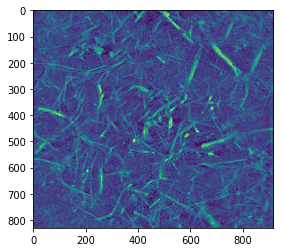

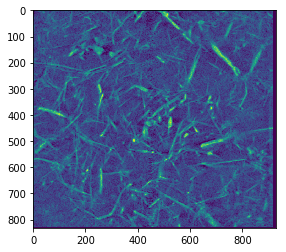

In [7]:

#load image and padd it to zero to be consistent with 32x32 tiles
path_to_raw='/media/csaba/ExtraDrive1/Tomography-SNW/20170210_Han/DataSetKlas/d_300_3mg_silver/'
index=115
image=io.imread(path_to_raw+'d_300_3mg_silver'+str(index).zfill(4)+'.tif')
plt.imshow(image)
plt.show()
padded_image_shape=map(lambda x: imsize*int(np.ceil(x/imsize)),np.shape(image))
padded_image=np.zeros(padded_image_shape)
padded_image[:np.shape(image)[0],:np.shape(image)[1]]=image/np.max(image).astype(float) #normalize to 0-1 
plt.imshow(padded_image)
plt.show()
n_vert_tiles,n_hor_tiles=int(padded_image_shape[0]/imsize),int(padded_image_shape[1]/imsize)


# Run the network on 32x32 subtiles of the image

In [8]:

#create placeholder for the analyzed images
filtered_x_proj=np.zeros(np.shape(padded_image))
filtered_y_proj=np.zeros(np.shape(filtered_x_proj))
filtered_intensity=np.zeros(np.shape(filtered_x_proj))

for tile_index in np.arange(0,n_vert_tiles*n_hor_tiles-2,batch_size): #total tiles is 29*26
    input_tensor=np.zeros( (batch_size,imsize,imsize,1) )
    for batch_index in range(batch_size):
        vert=(tile_index+batch_index)//n_hor_tiles
        hor=(tile_index+batch_index)%n_hor_tiles
        input_tensor[batch_index,:,:,0]=padded_image[vert*imsize:(vert+1)*imsize,hor*imsize:(hor+1)*imsize]
    #predict this batch
    predictions=sess.run([y_pred], feed_dict={x:input_tensor})
    predictions=np.asarray(predictions).reshape(batch_size,imsize,imsize,17)
    #put predictions into the dedicated 2D images filtered_x,y,intensity
    for batch_index in range(batch_size):
        vert=(tile_index+batch_index)//n_hor_tiles
        hor=(tile_index+batch_index)%n_hor_tiles
        filtered_x_proj[vert*imsize:(vert+1)*imsize,hor*imsize:(hor+1)*imsize]=predictions[batch_index,:,:,0]#0 is x
        filtered_y_proj[vert*imsize:(vert+1)*imsize,hor*imsize:(hor+1)*imsize]=predictions[batch_index,:,:,1]#1 is y
        filtered_intensity[vert*imsize:(vert+1)*imsize,hor*imsize:(hor+1)*imsize]=predictions[batch_index,:,:,-1]#-1 is I

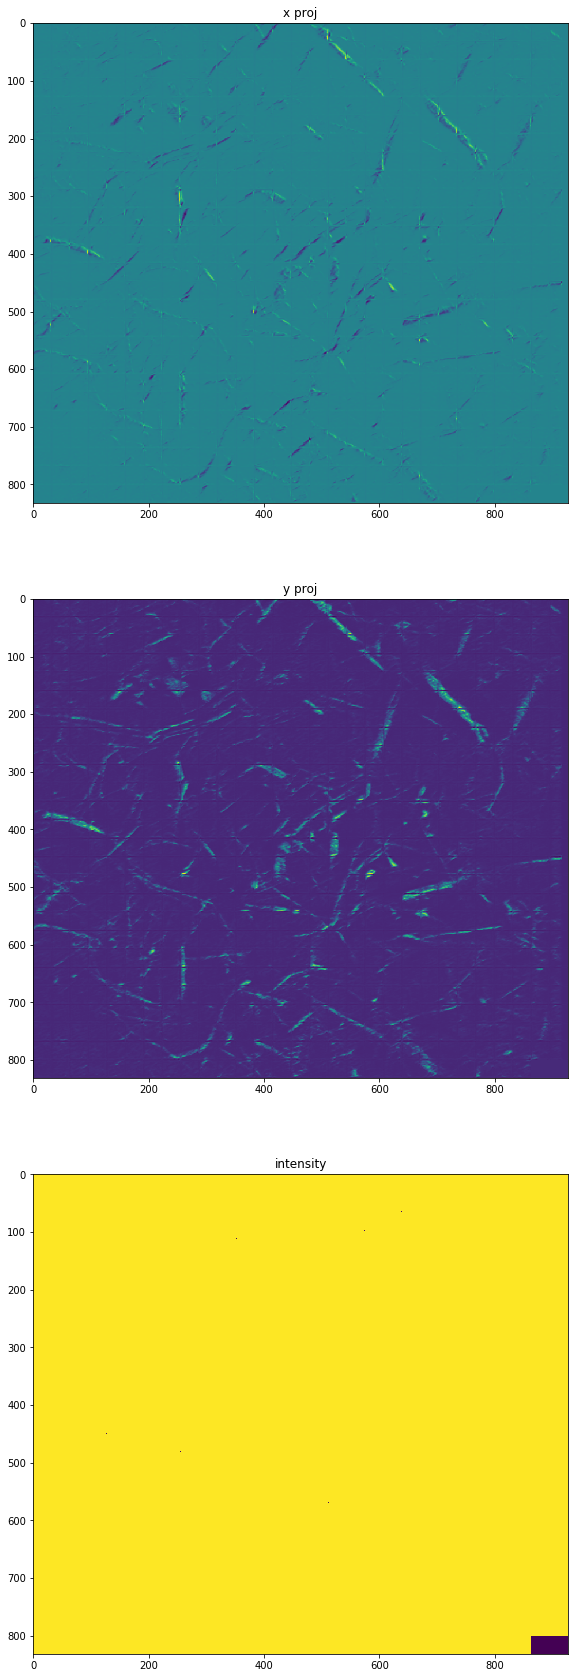

In [9]:
fig,ax=plt.subplots(3,1,figsize=(10,30))
ax[0].imshow(filtered_x_proj)
ax[0].set_title('x proj')
ax[1].imshow(filtered_y_proj)
ax[1].set_title('y proj')
ax[2].imshow(filtered_intensity)
ax[2].set_title('intensity')

plt.show()

# Can you enhance the contrast from those 3 dimensions of prediction

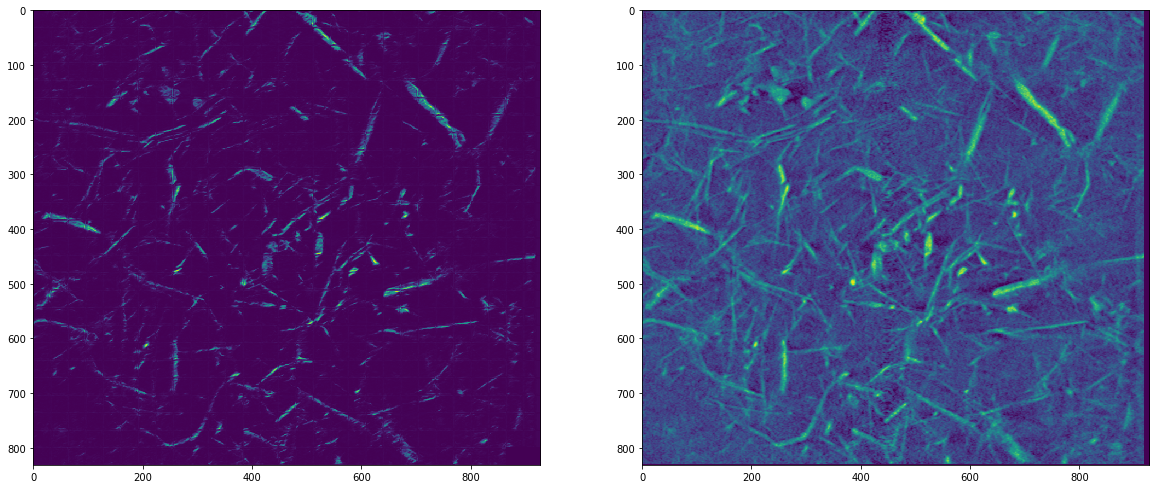

In [12]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(np.abs(filtered_x_proj)+np.abs(filtered_y_proj))
ax[1].imshow(padded_image)

plt.show()

In [82]:
vert,hor

(26, 0)